# **RQ2_Validity**

In [ ]:
pip install imagehash

In [ ]:
import numpy as np
from PIL import Image
from scipy.stats import norm
from math import ceil
import random
import imagehash


In [ ]:
def gather_diffgan_images(dataset, version_s, time_h, runs):
    images = []
    for num in runs:
        fi = np.load(f"/content/drive/MyDrive/Paper_Diff_testing/TestGAN_Run/{dataset}_S{version_s}/time_{int(time_h)}h/run{num}/Final_Triggering_Images.npy")
        images.append(fi)
    # Reshape and concatenate all images
    images = np.concatenate(images).reshape(-1, 28, 28, 1)
    return images


In [ ]:
def gather_drfuzz_images(dataset, version_s, time_h, runs):
    images = []
    for num in runs:
        fi = np.load(f"/content/drive/MyDrive/Paper_Diff_testing/DRFuzz-main/Failures_images/{dataset}_S{version_s}/time_{int(time_h)}h/TF_run{num}.npy")
        images.append(fi)
    images = np.concatenate(images).reshape(-1, 28, 28, 1)
    return images


In [ ]:
def select_random_subset(images, sample_size):
    indices = random.sample(range(len(images)), sample_size)
    return images[indices]

def prepare_data_for_labeling(diffgan_images, drfuzz_images):
    """
    Shuffle and label images from DiffGAN and DRFuzz for unbiased labeling.

    Parameters:
    diffgan_images (numpy.ndarray): Array of images from DiffGAN.
    drfuzz_images (numpy.ndarray): Array of images from DRFuzz.

    Returns:
    numpy.ndarray: Shuffled images for labeling.
    numpy.ndarray: Labels indicating the source (11 for DiffGAN, 22 for DRFuzz).
    """
    diffgan_set = [(image, 11) for image in diffgan_images]
    drfuzz_set = [(image, 22) for image in drfuzz_images]

    combined_set = diffgan_set + drfuzz_set
    random.shuffle(combined_set)

    shuffled_images, labels = zip(*combined_set)
    return np.array(shuffled_images), np.array(labels)


In [ ]:

def remove_redundant_images_with_hashing(images):
    """
    Remove redundant images from a dataset using simple hashing.

    Parameters:
    images (numpy.ndarray): Array of images to process.

    Returns:
    numpy.ndarray: Array of unique images.
    """
    # Compute a hash for each image
    image_hashes = [hash(image.tobytes()) for image in images]

    # Identify unique images by converting the list of hashes to a set
    unique_hashes = set(image_hashes)

    # Count unique images
    num_unique_images = len(unique_hashes)
    num_total_images = len(images)

    # Calculate redundancy
    redundancy_count = num_total_images - num_unique_images
    print(f"Redundant images removed: {redundancy_count}")

    # Extract unique images by matching hashes
    unique_images = []
    seen_hashes = set()
    for i, image_hash in enumerate(image_hashes):
        if image_hash not in seen_hashes:
            seen_hashes.add(image_hash)
            unique_images.append(images[i])

    # Convert the list of unique images to a numpy array
    return np.array(unique_images).reshape(-1, 28, 28, 1), redundancy_count



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def validate_and_label_images(total_images, total_label, num_users=3):
    """
    Display each image once and collect labels and validity checks from each user sequentially.

    Parameters:
    total_images (numpy.ndarray): Array of shuffled images.
    total_label (numpy.ndarray): Array indicating the source of each image (11 for DiffGAN, 22 for DRFuzz).
    num_users (int): Number of users to validate and label images.

    Returns:
    list: Array containing (image, user, validity, source) for all validations.
    """
    all_validations = []
    all_info = []
    num_images = len(total_images)
    figure_width, figure_height = 10, 5
    k=0
    for i in range(num_images):
        k=i
        image = total_images[i]
        source_label = total_label[i]
        plt.figure(figsize=(figure_width, figure_height))
        # Create two subplots side-by-side

        for jj in range(2):
            plt.subplot(1, 2, jj + 1)  # (1 row, 2 columns, subplot index)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(f'Image at Index {i}, source {source_label}' if jj == 0 else '')  # Title only on the first image
            plt.axis('off')  # Hide the axis
        plt.show()

        for user in range(1, num_users + 1):
            validity = input(f"User {user}: Is the image {i+1} valid? Enter 1 for valid, 0 for invalid: ").strip()
            while validity not in ['0', '1']:
                print("Invalid input. Please enter 0 or 1.")
                validity = input(f"User {user}: Is the image {i+1} valid? Enter 1 for valid, 0 for invalid: ").strip()
            validity = int(validity)

            if validity == 1 and i==k :
                ground_truth = input(f"User {user}: Enter the ground truth label for image {i+1} (0-9): ").strip()
                while not ground_truth.isdigit() or int(ground_truth) not in range(10):
                    print("Invalid input. Please enter a valid label (0-9).")
                    ground_truth = input(f"User {user}: Enter the ground truth label for image {i+1} (0-9): ").strip()
                ground_truth = int(ground_truth)
                k=k+1
                all_validations.append((i, user, ground_truth, source_label))

            all_info.append((i, user, validity, source_label))

    return all_info, all_validations

def aggregate_votes(all_validations, num_users=3):
    """
    Aggregate the votes for validity of images based on multiple users' inputs.

    Parameters:
    all_validations (list): List of tuples containing (image, user, validity, source).
    num_users (int): Number of users.

    Returns:
    list: Array containing (image, final_validity, source).
    """
    vote_counts = {}
    for validation in all_validations:
        id, user, validity, source = validation
        image_id = id  # Use id() to uniquely identify images
        if image_id not in vote_counts:
            vote_counts[image_id] = {'valid_votes': 0, 'invalid_votes': 0, 'image':id, 'source': source}
        if validity == 1:
            vote_counts[image_id]['valid_votes'] += 1
        else:
            vote_counts[image_id]['invalid_votes'] += 1

    final_validity_results = []
    for image_id, votes in vote_counts.items():
        final_validity = 1 if votes['valid_votes'] > votes['invalid_votes'] else 0
        final_validity_results.append((votes['image'], final_validity, votes['source']))

    return final_validity_results


In [ ]:
# Configuration parameters
dataset = "MNIST"
version_s = 1
time_h = 2
runs = [1,2,3]

# Gather DiffGAN images
diffgan_images = gather_diffgan_images(dataset, version_s, time_h, runs)
print("shape, number, diffgan",  len(diffgan_images))
diffgan_images_unique,_ = remove_redundant_images_with_hashing(diffgan_images)
print("shape, number, diffgan_uniq", diffgan_images_unique[0].shape,len(diffgan_images_unique))
# Gather DRFuzz images
runs_dr = [1,2,3]
drfuzz_images = gather_drfuzz_images(dataset, version_s, time_h, runs_dr)
print("shape, number, drfuzz", drfuzz_images.shape,len(drfuzz_images))
drfuzz_images_unique, redundancy_count = remove_redundant_images_with_hashing(drfuzz_images)

print("shape, number, drfuzz_uniq", drfuzz_images_unique.shape,len(drfuzz_images_unique))


# Calculate sample size for DiffGAN and DRFuzz separately
# len(diffgan_images_unique) 22483, 8676-redundancy_count
diffgan_sample_size = calculate_sample_size(len(diffgan_images_unique))
drfuzz_sample_size = calculate_sample_size(len(drfuzz_images_unique))
print("diffgan smaple size and drfuzz sample size", diffgan_sample_size, drfuzz_sample_size)
# Select random subsets for labeling from each method
diffgan_subset = select_random_subset(diffgan_images_unique, diffgan_sample_size)
drfuzz_subset = select_random_subset(drfuzz_images_unique, drfuzz_sample_size)
# Calculate total number of unique images
total_len = len(diffgan_subset) + len(drfuzz_subset)
print("total", total_len)
total_images, total_label= prepare_data_for_labeling(diffgan_subset, drfuzz_subset)
print("total images", total_images.shape)
# Validate and label images
# Validate and label the mixed images with 3 users, each providing input once
all_info, all_validations= validate_and_label_images(total_images, total_label, num_users=3)

# Perform voting to determine the final validity
final_validity_results = aggregate_votes(all_info)

# Now `final_validity_results` contains each image with its final validity and source.

print("all_images_info", np.array(all_validations).shape)
print("valid_images_info", np.array(final_validity_results).shape)

In [ ]:

print("all_images_info", np.array(all_validations).shape)
print("valid_images_info", np.array(final_validity_results).shape)

In [ ]:

# Perform voting to determine the final validity
final_validity_results = aggregate_votes(all_info)

# Now `final_validity_results` contains each image with its final validity and source.

print("all_images_info", len(all_validations))
print("valid_images_info", len(final_validity_results))

In [ ]:
def count_valid_images(all_validations, source_given):
    """
    Count images that are marked as valid and have a specific source label.

    Parameters:
    all_validations (list): List of tuples containing (image, user, validity, source).

    Returns:
    int: The count of valid images with source label 11.
    """
    valid_count = 0
    for  _, validity, source_label in all_validations:
        if validity == 1 and source_label == source_given:
            valid_count += 1

    return valid_count

# Example usage, assuming all_validations is already populated
valid_images_count = count_valid_images(final_validity_results,11)
#label 11 is DiffGAN
print(f"Number of valid images with source Diffgan: {valid_images_count}")


In [ ]:
import numpy as np

def bootstrap_valid_image_estimation(validity_results, num_bootstrap=1000, sample_size=None):
    """
    Perform bootstrapping to estimate the number of valid images in the entire dataset.

    Parameters:
    validity_results (numpy.ndarray): Array containing (index, validity) for a specific source (e.g., DiffGAN or DRFuzz).
    num_bootstrap (int): Number of bootstrap samples to generate.
    sample_size (int): Number of images to sample in each bootstrap iteration.

    Returns:
    tuple: Mean proportion of valid images, 95% confidence interval, estimated number of valid images, and bootstrap counts.
    """
    if sample_size is None:
        sample_size = len(validity_results)

    valid_image_counts = []

    for _ in range(num_bootstrap):
        # Generate random indices for the bootstrap sample
        indices = np.random.choice(len(validity_results), size=sample_size, replace=True)
        # Select the bootstrap sample using the generated indices
        bootstrap_sample = validity_results[indices]
        # Count the number of valid images (validity == 1) in the bootstrap sample
        valid_count = np.sum(bootstrap_sample[:, 1] == 1)
        valid_image_counts.append(valid_count)

    # Convert to numpy array for easier calculations
    valid_image_counts = np.array(valid_image_counts)

    # Calculate the mean proportion of valid images
    mean_valid_proportion = np.mean(valid_image_counts) / sample_size

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(valid_image_counts, 2.5) / sample_size
    upper_bound = np.percentile(valid_image_counts, 97.5) / sample_size

    # Estimate the total number of valid images in the entire dataset
    total_images_in_dataset = len(validity_results)
    estimated_valid_images = mean_valid_proportion * total_images_in_dataset

    return mean_valid_proportion, (lower_bound, upper_bound), estimated_valid_images, valid_image_counts


In [ ]:
final_validity_results=np.array(final_validity_results)

In [ ]:

import numpy as np

# Extract vectors with label 11 (DiffGAN)
diffgan_validity_results = final_validity_results[final_validity_results[:, 2] == 11][:, :2]

# Extract vectors with label 22 (DRFuzz)
drfuzz_validity_results = final_validity_results[final_validity_results[:, 2] == 22][:, :2]

# Now diffgan_validity_results and drfuzz_validity_results contain (index, 0/1) for labels 11 and 22, respectively


ss=len(diffgan_validity_results)
so=11


In [ ]:
# Example usage with diffgan_validity_results or drfuzz_validity_results
import matplotlib.pyplot as plt

mean_proportion, (ci_lower, ci_upper), estimated_valid_images, bootstrap_counts = bootstrap_valid_image_estimation(
    diffgan_validity_results, num_bootstrap=1000, sample_size=ss
)
print(f"size of sample: {ss}")
print(f"Mean proportion of valid images: {mean_proportion:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

valid_images_count = count_valid_images(final_validity_results,so)
print(f"Number of valid images: {valid_images_count}")
print(f"Estimated number of valid images in the entire dataset: {estimated_valid_images:.0f}")

# Plotting the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.mean(bootstrap_counts), color='red', linestyle='--', label=f'Mean: {np.mean(bootstrap_counts):.2f}')
plt.axvline(x=np.percentile(bootstrap_counts, 2.5), color='green', linestyle='--', label='2.5th Percentile')
plt.axvline(x=np.percentile(bootstrap_counts, 97.5), color='green', linestyle='--', label='97.5th Percentile')
plt.title('Bootstrap Distribution of Valid Image Counts')
plt.xlabel('Number of Valid Images in Bootstrap Samples')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Additional Analysis: Standard Error
standard_error = np.std(bootstrap_counts) / np.sqrt(ss)
print(f"Standard Error of the Mean Valid Image Count: {standard_error:.4f}")

# Plot the confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(x=['Valid Image Count'], y=[np.mean(bootstrap_counts)],
             yerr=[[np.mean(bootstrap_counts) - np.percentile(bootstrap_counts, 2.5)],
                   [np.percentile(bootstrap_counts, 97.5) - np.mean(bootstrap_counts)]],
             fmt='o', color='blue', ecolor='orange', capsize=10, label='95% CI')
plt.title('Mean Valid Image Count with 95% Confidence Interval')
plt.ylabel('Number of Valid Images')
plt.legend()
plt.show()

In [ ]:

bootstrap_validity_values = bootstrap_counts

# If you want to print or return the array
print("Bootstrap Validity Values:")
print(bootstrap_validity_values)

bootstrap_validity_list = bootstrap_validity_values.tolist()

validity_scores_Diffgan = bootstrap_counts / ss

# If you want to print or view the first few results for verification
print("Bootstrap Validity Scores (divided by sample size):")
print(validity_scores_Diffgan)


FOR  S4 (Scenario 4)

In [ ]:
# drfuzz_S4 = validity_scores_DRfuzz
diffgan_S4 = validity_scores_Diffgan

In [ ]:
# validity_Gan=[]
# validity_Fuzz=[]
validity_Gan.append(diffgan_S4)
validity_Fuzz.append(drfuzz_S4)

In [ ]:
validity_Gan=np.array(validity_Gan).reshape(4000)
validity_Fuzz=np.array(validity_Fuzz).reshape(4000)

In [ ]:
diffgan_S4 = validity_scores_Diffgan  # 1000 values for diffgan
drfuzz_S4 = validity_scores_DRfuzz

# Paired t-test
t_stat, p_val_t = ttest_rel(validity_Gan, validity_Fuzz)

# Wilcoxon signed-rank test
w_stat, p_val_w = wilcoxon(validity_Gan, validity_Fuzz)

# Compute the mean values of both sets
mean_diffgan = np.mean(validity_Gan)
mean_drfuzz = np.mean(validity_Fuzz)

# Output the results for the first pair
print(f"Paired t-test:\n t-statistic = {t_stat:.5f}, p-value = {p_val_t:.5f}")
print(f"Wilcoxon signed-rank test:\n w-statistic = {w_stat:.5f}, p-value = {p_val_w:.5f}")

# Compare means and print a conclusion
print(f"\nMean of diffgan scores: {mean_diffgan:.5f}")
print(f"Mean of drfuzz scores: {mean_drfuzz:.5f}")

if p_val_t < 0.05:
    if mean_diffgan > mean_drfuzz:
        print("Conclusion based on Paired t-test: Diffgan is significantly better than Drfuzz.")
    else:
        print("Conclusion based on Paired t-test: Drfuzz is significantly better than Diffgan.")
else:
    print("Conclusion based on Paired t-test: No significant difference between Diffgan and Drfuzz.")

if p_val_w < 0.05:
    if mean_diffgan > mean_drfuzz:
        print("Conclusion based on Wilcoxon signed-rank test: Diffgan is significantly better than Drfuzz.")
    else:
        print("Conclusion based on Wilcoxon signed-rank test: Drfuzz is significantly better than Diffgan.")
else:
    print("Conclusion based on Wilcoxon signed-rank test: No significant difference between Diffgan and Drfuzz.")


In [ ]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

# Replace these with your actual arrays of 1000 validity scores
diffgan_S1 = validity_scores_Diffgan  # 1000 values for diffgan
drfuzz_S1 = validity_scores_DRfuzz    # 1000 values for drfuzz

# Paired t-test
t_stat, p_val_t = ttest_rel(diffgan_S1, drfuzz_S1)

# Wilcoxon signed-rank test
w_stat, p_val_w = wilcoxon(diffgan_S1, drfuzz_S1)

# Compute the mean values of both sets
mean_diffgan = np.mean(diffgan_S1)
mean_drfuzz = np.mean(drfuzz_S1)

# Output the results for the first pair
print(f"Paired t-test:\n t-statistic = {t_stat:.5f}, p-value = {p_val_t:.5f}")
print(f"Wilcoxon signed-rank test:\n w-statistic = {w_stat:.5f}, p-value = {p_val_w:.5f}")

# Compare means and print a conclusion
print(f"\nMean of diffgan scores: {mean_diffgan:.5f}")
print(f"Mean of drfuzz scores: {mean_drfuzz:.5f}")

if p_val_t < 0.05:
    if mean_diffgan > mean_drfuzz:
        print("Conclusion based on Paired t-test: Diffgan is significantly better than Drfuzz.")
    else:
        print("Conclusion based on Paired t-test: Drfuzz is significantly better than Diffgan.")
else:
    print("Conclusion based on Paired t-test: No significant difference between Diffgan and Drfuzz.")

if p_val_w < 0.05:
    if mean_diffgan > mean_drfuzz:
        print("Conclusion based on Wilcoxon signed-rank test: Diffgan is significantly better than Drfuzz.")
    else:
        print("Conclusion based on Wilcoxon signed-rank test: Drfuzz is significantly better than Diffgan.")
else:
    print("Conclusion based on Wilcoxon signed-rank test: No significant difference between Diffgan and Drfuzz.")


In [ ]:
# Example usage with diffgan_validity_results or drfuzz_validity_results

mean_proportion, (ci_lower, ci_upper), estimated_valid_images, bootstrap_counts = bootstrap_valid_image_estimation(
    drfuzz_validity_results, num_bootstrap=1000, sample_size=ss
)
print(f"size of sample: {ss}")
print(f"Mean proportion of valid images: {mean_proportion:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

valid_images_count = count_valid_images(final_validity_results,so)
print(f"Number of valid images: {valid_images_count}")
print(f"Estimated number of valid images in the entire dataset: {estimated_valid_images:.0f}")

# Plotting the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.mean(bootstrap_counts), color='red', linestyle='--', label=f'Mean: {np.mean(bootstrap_counts):.2f}')
plt.axvline(x=np.percentile(bootstrap_counts, 2.5), color='green', linestyle='--', label='2.5th Percentile')
plt.axvline(x=np.percentile(bootstrap_counts, 97.5), color='green', linestyle='--', label='97.5th Percentile')
plt.title('Bootstrap Distribution of Valid Image Counts')
plt.xlabel('Number of Valid Images in Bootstrap Samples')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Additional Analysis: Standard Error
standard_error = np.std(bootstrap_counts) / np.sqrt(ss)
print(f"Standard Error of the Mean Valid Image Count: {standard_error:.4f}")

# Plot the confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(x=['Valid Image Count'], y=[np.mean(bootstrap_counts)],
             yerr=[[np.mean(bootstrap_counts) - np.percentile(bootstrap_counts, 2.5)],
                   [np.percentile(bootstrap_counts, 97.5) - np.mean(bootstrap_counts)]],
             fmt='o', color='blue', ecolor='orange', capsize=10, label='95% CI')
plt.title('Mean Valid Image Count with 95% Confidence Interval')
plt.ylabel('Number of Valid Images')
plt.legend()
plt.show()

In [ ]:
np.array(all_info).shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import numpy as np

array = np.zeros((diffgan_sample_size, 2), dtype=int)

array[:, 0] = np.arange(1, diffgan_sample_size+1)

indices = np.random.choice(diffgan_sample_size,  valid_images_count, replace=False)
array[indices, 1] = 1

# Display the resulting array
print(array.shape)

# Assuming Validated_sample is your array
Validated_sample = array  # Ensure it's a numpy array if not already

# Generate random indices without replacement
indices = np.random.choice(Validated_sample.shape[0], diffgan_sample_size, replace=False)

# Select the rows corresponding to these indices
selected_rows = Validated_sample[indices]
# ground=np.array(ground_truth_labels)[indices]

#Validated_sample contains tuples of (index, validity_flag)
# Example: Validated_sample = [(0, 1), (1, 0), ...]
Validated_sample=array
# Calculate initial proportion of valid images
initial_valid_proportion = np.mean([x[1] for x in Validated_sample])
print(f"Initial proportion of valid images: {initial_valid_proportion}")


def bootstrap_resample(validated_sample, n_iterations=1000):
    proportions = []
    for _ in range(n_iterations):
        # Sample with replacement from the validated sample
        bootstrap_sample = np.random.choice([x[1] for x in validated_sample], size=len(validated_sample), replace=True)
        # Calculate proportion of valid images in the bootstrap sample
        proportion_valid = np.mean(bootstrap_sample)
        proportions.append(proportion_valid)
    return proportions

# Perform bootstrapping from the validated sample
bootstrap_proportions = bootstrap_resample(Validated_sample)

# Plotting the distribution of valid image proportions across bootstrap samples
plt.hist(bootstrap_proportions, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Valid Image Proportions Across Bootstrap Samples')
plt.xlabel('Proportion of Valid Images')
plt.ylabel('Frequency')
plt.show()

In [ ]:

valid_images_count_DR = count_valid_images(final_validity_results,22)
print(f"Number of valid images with source label 22: {valid_images_count_DR}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import numpy as np

array = np.zeros((drfuzz_sample_size, 2), dtype=int)

array[:, 0] = np.arange(1, drfuzz_sample_size+1)

indices = np.random.choice(drfuzz_sample_size,  valid_images_count_DR, replace=False)
array[indices, 1] = 1

# Display the resulting array
print(array.shape)

# Assuming Validated_sample is your array
Validated_sample = array  # Ensure it's a numpy array if not already

# Generate random indices without replacement
indices = np.random.choice(Validated_sample.shape[0], drfuzz_sample_size, replace=False)

# Select the rows corresponding to these indices
selected_rows = Validated_sample[indices]
# ground=np.array(ground_truth_labels)[indices]

#Validated_sample contains tuples of (index, validity_flag)
# Example: Validated_sample = [(0, 1), (1, 0), ...]
Validated_sample=array
# Calculate initial proportion of valid images
initial_valid_proportion = np.mean([x[1] for x in Validated_sample])
print(f"Initial proportion of valid images: {initial_valid_proportion}")


def bootstrap_resample(validated_sample, n_iterations=1000):
    proportions = []
    for _ in range(n_iterations):
        # Sample with replacement from the validated sample
        bootstrap_sample = np.random.choice([x[1] for x in validated_sample], size=len(validated_sample), replace=True)
        # Calculate proportion of valid images in the bootstrap sample
        proportion_valid = np.mean(bootstrap_sample)
        proportions.append(proportion_valid)
    return proportions

# Perform bootstrapping from the validated sample
bootstrap_proportions = bootstrap_resample(Validated_sample)

# Plotting the distribution of valid image proportions across bootstrap samples
plt.hist(bootstrap_proportions, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Valid Image Proportions Across Bootstrap Samples')
plt.xlabel('Proportion of Valid Images')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_valid_image_estimation(all_validations, source_given, num_bootstrap=1000, sample_size=None):
    """
    Perform bootstrapping to estimate the number of valid images in the entire dataset.

    Parameters:
    all_validations (list): List of tuples containing (image, validity, source).
    source_given (int): The source label to filter the valid images (e.g., 11 for DiffGAN).
    num_bootstrap (int): Number of bootstrap samples to generate.
    sample_size (int): Number of images to sample in each bootstrap iteration.

    Returns:
    tuple: Mean proportion of valid images, 95% confidence interval, estimated number of valid images, and bootstrap counts.
    """
    if sample_size is None:
        sample_size = len(all_validations)

    valid_image_counts = []

    for _ in range(num_bootstrap):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = np.random.choice(all_validations, size=sample_size, replace=True)
        # Count the number of valid images with the specified source label in the bootstrap sample
        valid_count = count_valid_images(bootstrap_sample, source_given)
        valid_image_counts.append(valid_count)

    # Convert to numpy array for easier calculations
    valid_image_counts = np.array(valid_image_counts)

    # Calculate the mean proportion of valid images
    mean_valid_proportion = np.mean(valid_image_counts) / sample_size

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(valid_image_counts, 2.5) / sample_size
    upper_bound = np.percentile(valid_image_counts, 97.5) / sample_size

    # Estimate the total number of valid images in the entire dataset
    total_images_in_dataset = len(all_validations)
    estimated_valid_images = mean_valid_proportion * total_images_in_dataset

    return mean_valid_proportion, (lower_bound, upper_bound), estimated_valid_images, valid_image_counts

# Example usage
mean_proportion, (ci_lower, ci_upper), estimated_valid_images, bootstrap_counts = bootstrap_valid_image_estimation(
    final_validity_results, source_given=11, num_bootstrap=1000, sample_size=300
)

print(f"Mean proportion of valid images: {mean_proportion:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Estimated number of valid images in the entire dataset: {estimated_valid_images:.0f}")

# Plotting the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.mean(bootstrap_counts), color='red', linestyle='--', label=f'Mean: {np.mean(bootstrap_counts):.2f}')
plt.axvline(x=np.percentile(bootstrap_counts, 2.5), color='green', linestyle='--', label='2.5th Percentile')
plt.axvline(x=np.percentile(bootstrap_counts, 97.5), color='green', linestyle='--', label='97.5th Percentile')
plt.title('Bootstrap Distribution of Valid Image Counts')
plt.xlabel('Number of Valid Images in Bootstrap Samples')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Additional Analysis: Standard Error
standard_error = np.std(bootstrap_counts) / np.sqrt(sample_size)
print(f"Standard Error of the Mean Valid Image Count: {standard_error:.4f}")

# Plot the confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(x=['Valid Image Count'], y=[np.mean(bootstrap_counts)],
             yerr=[[np.mean(bootstrap_counts) - np.percentile(bootstrap_counts, 2.5)],
                   [np.percentile(bootstrap_counts, 97.5) - np.mean(bootstrap_counts)]],
             fmt='o', color='blue', ecolor='orange', capsize=10, label='95% CI')
plt.title('Mean Valid Image Count with 95% Confidence Interval')
plt.ylabel('Number of Valid Images')
plt.legend()
plt.show()


In [ ]:
def calculate_sample_size(population_size, p_hat=0.5, margin_of_error=0.05, confidence_level=0.95):
    """
    Calculate the sample size required for manual labeling, adjusted for a finite population.

    Parameters:
    population_size (int): Total number of unique images in the dataset.
    p_hat (float): Estimated proportion of the characteristic of interest (default is 0.5 for maximum variability).
    margin_of_error (float): Desired margin of error.
    confidence_level (float): Desired confidence level (default is 0.95).

    Returns:
    int: Calculated sample size.
    """
    # Z-score for the desired confidence level
    z_score = norm.ppf(1 - (1 - confidence_level) / 2)

    # Sample size calculation for an infinite population
    sample_size = ((z_score**2) * p_hat * (1 - p_hat)) / (margin_of_error**2)

    # Finite population correction
    finite_sample_size = sample_size / (1 + ((sample_size - 1) / population_size))

    # Return the ceiling of the sample size as it must be an integer
    return int(np.ceil(finite_sample_size))



#RQ3_ **Diversty**

In [ ]:
!pip install scikit-bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 61.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=3962610 sha256=b734acb35c9876219a49393df26739ca2c336bc346680af94d89aa1ed872ecc2
  Stored in directory: /root/.cache/pip/wheels/f3/9c/ed/c2b94011fd3765a19330df93f81265e178098dd86c047c1566
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-linux_x86_64.whl size=12158824 sha256=4a80c3405b5fa242e12658536e8cc12f6756892fc246906a64fdf9c416a6538e
  Stored in directory: /root/.cache/pip/wheels/8e/a9/f9/197fd5a0e5bbab5f2e03c89194f6c194bed7af5d7a8c8759f3
Successf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.optimizer_v2.adam import Adam
import cv2
from scipy import io
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib import pyplot
import argparse
import array
import cProfile
import copy
import math
import multiprocessing
import random
import shutil
import string
import sys
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
from keras import backend as K
from keras import layers
from keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D)
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from scipy.io import loadmat
from scipy.linalg import qr
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.datasets import cifar10, cifar100, fashion_mnist, mnist
from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

# Install packages in your environment
!pip install pymoo
!pip install NearPy
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.callback import Callback
from pymoo.core.crossover import Crossover
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.mutation import Mutation
from pymoo.core.problem import ElementwiseProblem
from pymoo.problems import get_problem
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.core.termination import Termination
from pymoo.optimize import minimize
from pymoo.core.sampling import Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation

from pymoo.termination import get_termination
import cProfile
import pstats

import numpy as np
from PIL import Image

# !pip install numpy pandas scipy

!pip install hdbscan
!pip install umap-learn

import numpy as np
import hdbscan
import umap
from sklearn.metrics.pairwise import cosine_similarity
!pip install pytorch_fid


import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
%load_ext autoreload
%autoreload 2


# !pip install pytorch_fid
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from pytorch_fid import fid_score
import os
from tempfile import TemporaryDirectory


(_,_), (X_N_test, y_test) = cifar10.load_data()
def normalize_images(images):
    min_val = images.min(axis=(1, 2, 3), keepdims=True)
    max_val = images.max(axis=(1, 2, 3), keepdims=True)
    normalized_images = (images - min_val) / (max_val - min_val)
    return normalized_images
y_test = y_test.flatten()

X_N_test=normalize_images(X_N_test)

# Load the first DNN model
model1 = keras.models.load_model(".../Paper_Diff_testing/DNN_Models/cifar10_Model7_v4.h5')

# Load the second DNN model
model2 = keras.models.load_model('.../Paper_Diff_testing/DNN_Models/cifar10_Model8_v4.h5')



# Define the generator model (based on the repository's model definition)
class Generator(torch.nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

import os
import matplotlib.pyplot as plt
import numpy as np
import time

import os
import numpy as np
import hdbscan
import umap
from numba import jit, prange
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import hdbscan
import umap
from numba import jit, prange

@jit(nopython=True, parallel=True)
def cosine_similarity(u, v):
    u_norm = np.linalg.norm(u)
    v_norm = np.linalg.norm(v)
    if u_norm == 0 or v_norm == 0:
        return 0.0
    else:
        return np.dot(u, v) / (u_norm * v_norm)


def normalize_images(images):
    min_vals = images.min(axis=(1, 2), keepdims=True)
    max_vals = images.max(axis=(1, 2), keepdims=True)
    normalized_images = (images - min_vals) / (max_vals - min_vals + 1e-8)
    return normalized_images


@np.vectorize
def man_dist(a, b):
    a_sum = np.sum(np.abs(a))
    b_sum = np.sum(np.abs(b))
    if a_sum != 0:
        a /= a_sum
    if b_sum != 0:
        b /= b_sum
    dist = np.sum(np.abs(a - b))
    if np.argmax(a) == np.argmax(b):
        return -dist
    else:
        return -(dist + 1)

@np.vectorize
def neg_kl_divergence(p, q):
    kl_div = entropy(p, q)
    if np.argmax(p) == np.argmax(q):
        return -kl_div
    else:
        return -(kl_div + 1)

def generate_and_classify(vectors, generator, dnn1, dnn2, real_images, ssim_threshold=0.6, Display=False):
    with torch.no_grad():
        gg = generator(vectors)
        generated_images = gg.cpu().numpy().transpose(0, 2, 3, 1)

    device = torch.device('cuda')
    generator.to(device)

    normalized_data = normalize_images(generated_images)
    Ob1 = dnn1.predict(normalized_data)
    Ob2 = dnn2.predict(normalized_data)

    if Display:
        ssim_scores = filter_images_by_ssim_with_threshold(normalized_data, real_images)
        plt.figure(figsize=(len(vectors) * 3, 3))
        min_val = normalized_data.min()
        max_val = normalized_data.max()
        normalized_images = (normalized_data - min_val) / (max_val - min_val)

        for i in range(generated_images.shape[0]):
            hh = "Valid" if ssim_scores[i] > ssim_threshold else "Invalid"
            plt.subplot(1, len(vectors), i + 1)
            plt.imshow(normalized_data[i])
            plt.title(f"Img {i+1}\nLabel1: {np.argmax(Ob1[i])}\nLabel2: {np.argmax(Ob2[i])}\nSSIM: {ssim_scores[i]:.2f}- {hh}")
            plt.axis('off')
        plt.show()

    return Ob1, Ob2, gg



def calculate_ssim(image1, image2):
    # Calculate the SSIM score between two images
    if np.array_equal(image1, image2):
        return 1.0

    return ssim(image1, image2, multichannel=True)


def filter_images_by_ssim_with_threshold(generated_images, reference_images):
    filtered_images = []
    filtered_images_labels = []
    ssim_scores = []
    jj=0

    # Create the hash engine for approximate similarity search
    dimension = generated_images[0].flatten().shape[0]
    num_hash_bits = 10
    num_hash_functions = 2
    hashes = [RandomBinaryProjections('hash{}'.format(i), num_hash_bits) for i in range(num_hash_functions)]
    engine = Engine(dimension, lshashes=hashes)

    # Add the reference images to the engine
    for i, image in enumerate(reference_images):
        image_flat = image.flatten()
        engine.store_vector(image_flat, 'ref{}'.format(i))

    with ThreadPoolExecutor() as executor:
        for h, generated_image in enumerate(generated_images):
            # print(h)
            most_similar_index = None
            max_ssim_score = -np.inf

            # Hash the generated image and find approximate neighbors
            generated_image_flat = generated_image.flatten()
            neighbors = engine.neighbours(generated_image_flat)
            for _, ref_id, _ in neighbors:
                ref_image = reference_images[int(ref_id.replace('ref', ''))]
                ssim_score = calculate_ssim(generated_image, ref_image)


                if ssim_score > max_ssim_score:
                    max_ssim_score = ssim_score
                    most_similar_index = int(ref_id.replace('ref', ''))

            most_similar_image = reference_images[most_similar_index]
            # print("LLLLLLLLLLLLLLLLLLLLLL", max_ssim_score)
            ssim_scores.append(max_ssim_score)
            ##########################################################################################################################
            ##########################################################################################################################
            ##########     NOTE:               If you wanted to call this function alone you can comment out these lines  ############
            ##########################################################################################################################
            ##########################################################################################################################
            # if max_ssim_score <= threshold:
            #     filtered_images.append(generated_image)
            #     filtered_images_labels.append(h)
            # else:
            #     jj=jj+1


    # return filtered_images, filtered_images_labels, ssim_scores
    return  ssim_scores




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=ff95988595e01bc20fe6abd69062547fc12d631c1c392e67e2830a6602fa7673
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import cv2
import random
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, Model
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from scipy.stats import entropy



def load_and_preprocess_images(images):
    """
    Load and preprocess images

    Args:
        images (numpy array): Array of images.

    Returns:
        list: List of PIL images.
        numpy array: Array of resized and normalized images.
    """
    # Convert images to PIL Images for resizing
    pil_images = [Image.fromarray((img * 255).astype(np.uint8)) for img in images]

    # Resize images to 299x299 pixels
    x_subset_resized = np.array([smart_resize(img, (299, 299)) for img in images])

    # Normalize images to the range [-1, 1]
    x_max = x_subset_resized.max()
    x_min = x_subset_resized.min()
    x_subset_normalized = 2 * (x_subset_resized - x_min) / (x_max - x_min) - 1

    return pil_images, x_subset_normalized


def extract_features(images):
    """
    Extract features from images using the InceptionV3 model.

    Args:
        images (numpy array): Array of preprocessed images.

    Returns:
        numpy array: Array of extracted features.
    """
    # Load pre-trained InceptionV3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Extract features from images using the Inception model
    return inception_model.predict(images)


def resize_image(image, target_size):
    old_size = image.shape[:2]
    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = target_size - new_size[1]
    delta_h = target_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image

def GD(features):
    dot_p = np.dot(features, features.T)
    sign, Log_det = np.linalg.slogdet(dot_p)
    return abs(Log_det)


def shannon_entropy(features):
    distances = pdist(features, 'euclidean')
    histogram, _ = np.histogram(distances, bins='auto', density=True)
    return entropy(histogram)


In [ ]:
from skbio.diversity.alpha import shannon
import numpy as np

def calculate_shannon_index_skbio(counts):
    """
    Calculate the Shannon Index using scikit-bio's shannon function.

    Parameters:
    counts (array-like): An array of counts for each category.

    Returns:
    float: The Shannon Index.
    """
    return shannon(counts)

# # Example usage
# counts = [10, 20, 30, 40]  # Replace with your data
# print("Shannon Index (scikit-bio):", calculate_shannon_index_skbio(images[:10].flatten()))


MNIST

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from keras.applications.vgg16 import VGG16
from keras.layers import Input
from keras.models import Model
from skimage.transform import resize
from skbio.diversity.alpha import shannon
from hashlib import md5
import pandas as pd

# Function to plot images
def plot_images(images, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')  # Hide axis
    plt.show()

# Function to calculate redundant images
def calculate_redundant_images(images_array):
    hash_dict = {}
    redundant_pairs = 0

    for img in images_array:
        # Normalize and convert the image to bytes for hashing
        normalized_img = img.astype("float32").tobytes()
        img_hash = md5(normalized_img).hexdigest()

        if img_hash in hash_dict:
            hash_dict[img_hash] += 1
        else:
            hash_dict[img_hash] = 1

    for count in hash_dict.values():
        if count > 1:
            redundant_pairs += count * (count - 1) // 2

    return redundant_pairs

# Load VGG16 model
input_layer = Input(shape=(48, 48, 3))
model_vgg16 = VGG16(weights='imagenet', input_tensor=input_layer, include_top=False)
name_layer = 'block5_conv3'
intermediate_layer_model = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer(name_layer).output)

# Directory structure
base_dir = ".../Paper_Diff_testing/TestGAN_Run/MNIST_S"
# {Version_S}/time_{int(time_h)}h/run{num}/Final_Triggering_Images.npy
# Results table
results = []

# Iterate through scenarios, times, and runs
for scenario in [4]:
    for time in ["3h"]:
        for run in ["run1", "run2", "run3"]:
            path = f"{base_dir}{scenario}/time_{time}/{run}/Final_Triggering_Images.npy"
            hh = np.load(path, allow_pickle=True)

            print(f"Scenario {scenario}, Time {time}, {run}")
            print("trig:", len(hh))

            images_hh = [hh[i].reshape(28, 28, 1) for i in range(len(hh))]
            images_array = np.array(images_hh)

            # Check min and max values before normalization
            min_val = images_array.min()
            max_val = images_array.max()
            images_array = (images_array - min_val) / (max_val - min_val)

            # Number of repetitions and subset size
            num_repetitions =30
            subset_size = 1000

            # Initialize dictionaries to store cumulative scores
            cumulative_scores_DR = {
                "Geometric Diversity (GD)": 0,
                "Shannon F": 0,
                "Shannon P": 0
            }

            for _ in range(num_repetitions):
                # Select a random sample
                sample_indices = random.sample(range(len(images_array)), subset_size)
                images_DR = images_array[sample_indices]

                # Resize the images to 48x48 as required by VGG16
                x_test_DR = np.array([resize(im, (48, 48, 3)) for im in images_DR])
                x_test_DR = x_test_DR.astype("float32")

                # Extract features
                FF_DR = intermediate_layer_model.predict(x_test_DR)
                features_DR = FF_DR.reshape((len(x_test_DR), -1))
                gd_score = GD(features_DR)
                if np.isinf(gd_score):
                    gd_score = 0.0

                # Calculate diversity scores for this subset
                diversity_scores = {
                    "Geometric Diversity (GD)": gd_score,
                    "Shannon P": shannon(images_DR.flatten())
                }

                # Accumulate scores
                for metric, score in diversity_scores.items():
                    cumulative_scores_DR[metric] += score

            # Calculate average scores
            average_scores_DR = {metric: score / num_repetitions for metric, score in cumulative_scores_DR.items()}

            # Calculate number of redundant images
            redundant_count = calculate_redundant_images(images_array)

            # Store results
            results.append([scenario, time, run, average_scores_DR["Geometric Diversity (GD)"], average_scores_DR["Shannon P"], redundant_count])

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results, columns=["Scenario", "Time", "Run", "Geometric Diversity (GD)",
                                            "Shannon P", "Redundant Images"])

# import ace_tools as tools; tools.display_dataframe_to_user(name="Diversity and Redundancy Results", dataframe=results_df)
print(results_df)


In [ ]:
import numpy as np
dataset= "CIFAR10"
Version_S = 4
time_h=3
num=3
# Load the image array
images = np.load(f".../Paper_Diff_testing/TestGAN_Run/{dataset}_S{Version_S}/time_{int(time_h)}h/run{num}/Final_Triggering_Images_F.npy")

# Compute a hash for each image
image_hashes = [hash(image.tobytes()) for image in images]

# Identify unique images by converting the list of hashes to a set
unique_hashes = set(image_hashes)

# Count unique images
num_unique_images = len(unique_hashes)
num_total_images = len(images)

# Calculate redundancy
redundancy_count = num_total_images - num_unique_images

print(f"Total images: {num_total_images}")
print(f"Unique images: {num_unique_images}")
print(f"Redundant images: {redundancy_count}")
images = images.reshape(-1, 32, 32, 3)
print("",images.max(), images.min(), images.shape)


Total images: 436609
Unique images: 436609
Redundant images: 0
 1.0 0.0 (436609, 32, 32, 3)


In [ ]:
# Number of repetitions and subset size
num_repetitions = 30
subset_size = 1000
# random.seed(122)
# np.random.seed(122)

# Initialize dictionaries to store cumulative scores
cumulative_scores_ = {
    "Geometric Diversity (GD)": 0,
    "Shannon P": 0
}

# Load VGG16 model
input_layer = layers.Input(shape=(48, 48, 3))
model_vgg16 = VGG16(weights='imagenet', input_tensor=input_layer, include_top=False)
name_layer = 'block5_conv3'
intermediate_layer_model = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer(name_layer).output)

for _ in range(num_repetitions):
    # Select a random sample
    sample_indices= random.sample(range(len(images)), subset_size)
    images_ = images[sample_indices]

    # Resize the images to 48x48 as required by VGG16
    x_test_ = np.array([resize_image(im, 48) for im in images_])
    x_test_ = x_test_.astype("float32")

    # Extract features
    FF_ = intermediate_layer_model.predict(x_test_)
    features_ = FF_.reshape((len(x_test_), -1))
    gd_score = GD(features_)
    if np.isinf(gd_score):
        gd_score = 0.0
    # Calculate diversity scores for this subset
    diversity_scores = {
        "Geometric Diversity (GD)": gd_score,
        "Shannon P": calculate_shannon_index_skbio(images_.flatten())
    }

    # Accumulate scores
    for metric, score in diversity_scores.items():
        cumulative_scores_[metric] += score

# Calculate average scores
average_scores_ = {metric: score / num_repetitions for metric, score in cumulative_scores_.items()}

# Print the average diversity scores
for metric, score in average_scores_.items():
    print(f"Average {metric}: {score}")



In [ ]:
import numpy as np
from hashlib import md5

def calculate_redundant_images(images_array):
    """
    Calculate the number of redundant or completely similar images in the image array.

    Parameters:
    images_array (numpy.ndarray): Array of images with shape (num_images, height, width, channels)

    Returns:
    int: Number of redundant image pairs
    """
    hash_dict = {}
    redundant_pairs = 0

    for img in images_array:
        # Normalize and convert the image to bytes for hashing
        normalized_img = img.astype("float32").tobytes()
        img_hash = md5(normalized_img).hexdigest()

        if img_hash in hash_dict:
            hash_dict[img_hash] += 1
        else:
            hash_dict[img_hash] = 1

    for count in hash_dict.values():
        if count > 1:
            redundant_pairs += count * (count - 1) // 2

    return redundant_pairs

# Example usage:
redundant_count = calculate_redundant_images(images)

print(f"Number of redundant image pairs: {redundant_count}")


Number of redundant image pairs: 0


##DRFUZZ Diversity

In [ ]:
import os
import os
path_to_dir=".../Paper_Diff_testing/DRFuzz-main"
os.chdir(path_to_dir)
print("current path", os.getcwd())
!pip install -r requirement.txt
!pip install cleverhans --upgrade



!pip install git+https://github.com/CNOCycle/cleverhans.git@feature/tf2.x
# Define the path to the file
file_path = '/usr/local/lib/python3.10/dist-packages/cleverhans/utils_tf.py'

# Check if the file exists
if os.path.exists(file_path):
    # Read the file content
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Replace the specific line
    for i, line in enumerate(lines):
        if "loss_collection=tf.GraphKeys.REGULARIZATION_LOSSES):" in line:
            lines[i] = "loss_collection=tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES): \n"
            break

    # Write back the modified content
    with open(file_path, 'w') as file:
        file.writelines(lines)

    print("File updated successfully.")
else:
    print(f"The file at {file_path} was not found.")


class TestCase:
    def __init__(self, input, ground_truth, source_id):
        self.input = input
        self.label = ground_truth
        self.source_id = source_id
        self.generation = 0
        self.exploration_multiple = 1
        self.ori_image = input
        self.ref_image = input
        self.m1_trace = []
        self.m2_trace = []
        self.m1_predict_label = -1
        self.m2_predict_label = -1
        self.save_in_queue_time = -1
        self.mutation_trace = []
        self.corpus_id = -1
        self.last_corpus_trace = []
        self.fidelity = -1
        self.select_prob = self.calculate_select_prob(self.generation, 0)

    def update_ref(self, new_ref_image):
        self.ref_image = new_ref_image

    def update_save_in_queue_time(self, official_saved_time):
        self.save_in_queue_time = official_saved_time

    def set_trace(self, new_m1_trace, new_m2_trace):
        self.m1_trace = new_m1_trace
        self.m2_trace = new_m2_trace
        self.m1_predict_label = np.argmax(self.m1_trace)
        self.m2_predict_label = np.argmax(self.m2_trace)

    def get_test_failure_tend(self):
        if self.m1_predict_label == self.label and self.m1_predict_label == self.m2_predict_label and self.m1_predict_label != -1 and self.m2_predict_label != -1:
            failure_trace = self.m2_trace - self.m1_trace
            failure_trace[self.m1_predict_label] = -1
            failure_direction = np.argmax(failure_trace)
            return (self.source_id, self.m1_predict_label, failure_direction)
        else:
            if self.m1_predict_label == self.label and self.m2_predict_label != self.label:
                return 'rf'
            return None

    def get_test_tend(self):
        return (self.source_id, self.m1_predict_label, self.m2_predict_label)

    def get_all_test_failure_tends_dicts(self):
        classnum = len(self.m1_trace)
        failure_trace = self.m2_trace - self.m1_trace
        failure_trace_dicts = {}
        for i in range(classnum):
            if self.m1_predict_label == self.label and self.m2_predict_label != i:
                failure_trace_dicts[(self.source_id, self.m1_predict_label, i)] = failure_trace[i]
        return failure_trace_dicts

    def get_difference(self):
        return (self.m1_trace[self.label] - self.m2_trace[self.label])

    def get_relative_difference(self):
        epsilon = 1e-7
        return (self.m1_trace[self.label] - self.m2_trace[self.label]) / (self.m1_trace[self.label] + epsilon)

    def calculate_select_prob(self, generation, select_times, init=1, m=20, finish=0.05):
        delt_times = 10
        if select_times > delt_times:
            return 0

        alpha = np.log(init / finish) / m
        l = - np.log(init) / alpha
        decay = np.exp(-alpha * (float(generation + select_times / 2.0) + l))

        if decay == np.nan:
            decay = 0
        return decay





In [ ]:
np.array(images_hh).min()

0.0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from keras.applications.vgg16 import VGG16
from keras.layers import Input
from keras.models import Model
from skimage.transform import resize
from skbio.diversity.alpha import shannon
from hashlib import md5
import pandas as pd

# Function to plot images
def plot_images(images, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')  # Hide axis
    plt.show()

# Function to calculate redundant images
def calculate_redundant_images(images_array):
    hash_dict = {}
    redundant_pairs = 0

    for img in images_array:
        # Normalize and convert the image to bytes for hashing
        normalized_img = img.astype("float32").tobytes()
        img_hash = md5(normalized_img).hexdigest()

        if img_hash in hash_dict:
            hash_dict[img_hash] += 1
        else:
            hash_dict[img_hash] = 1

    for count in hash_dict.values():
        if count > 1:
            redundant_pairs += count * (count - 1) // 2

    return redundant_pairs

# Load VGG16 model
input_layer = Input(shape=(48, 48, 3))
model_vgg16 = VGG16(weights='imagenet', input_tensor=input_layer, include_top=False)
name_layer = 'block5_conv3'
intermediate_layer_model = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer(name_layer).output)

# Directory structure
base_dir = ".../Paper_Diff_testing/DRFuzz-main/Failures_images/MNIST_S"

# Results table
results = []

# Iterate through scenarios, times, and runs
for scenario in [1,2,3,4]:
    for time in ["1h", "2h", "3h"]:
        for run in ["run1", "run2", "run3"]:
            path = f"{base_dir}{scenario}/time_{time}/TF_{run}.npy"
            hh = np.load(path, allow_pickle=True)

            print(f"Scenario {scenario}, Time {time}, {run}")
            print("trig:", len(hh))

            images_hh = [hh[i].reshape(28, 28, 1) for i in range(len(hh))]
            images_array = np.array(images_hh)

            # Check min and max values before normalization
            min_val = images_array.min()
            max_val = images_array.max()
            images_array = (images_array - min_val) / (max_val - min_val)

            # Number of repetitions and subset size
            num_repetitions = 30
            subset_size = 1000

            # Initialize dictionaries to store cumulative scores
            cumulative_scores_DR = {
                "Geometric Diversity (GD)": 0,
                "Shannon F": 0,
                "Shannon P": 0
            }

            for _ in range(num_repetitions):
                # Select a random sample
                if len(images_array)< 1000:
                  subset_size = len(images_array)
                sample_indices = random.sample(range(len(images_array)), subset_size)
                images_DR = images_array[sample_indices]

                # Resize the images to 48x48 as required by VGG16
                x_test_DR = np.array([resize(im, (48, 48, 3)) for im in images_DR])
                x_test_DR = x_test_DR.astype("float32")

                # Extract features
                FF_DR = intermediate_layer_model.predict(x_test_DR)
                features_DR = FF_DR.reshape((len(x_test_DR), -1))
                gd_score = GD(features_DR)
                if np.isinf(gd_score):
                    gd_score = 0.0

                # Calculate diversity scores for this subset
                diversity_scores = {
                    "Geometric Diversity (GD)": gd_score,
                    "Shannon P": shannon(images_DR.flatten())
                }

                # Accumulate scores
                for metric, score in diversity_scores.items():
                    cumulative_scores_DR[metric] += score

            # Calculate average scores
            average_scores_DR = {metric: score / num_repetitions for metric, score in cumulative_scores_DR.items()}

            # Calculate number of redundant images
            redundant_count = calculate_redundant_images(images_array)

            # Store results
            results.append([scenario, time, run, average_scores_DR["Geometric Diversity (GD)"], average_scores_DR["Shannon P"], redundant_count])

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results, columns=["Scenario", "Time", "Run", "Geometric Diversity (GD)",
                                            "Shannon P", "Redundant Images"])

# import ace_tools as tools; tools.display_dataframe_to_user(name="Diversity and Redundancy Results", dataframe=results_df)
print(results_df)


Scenario 1, Time 1h, run1
trig: 1311
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 1h, run2
trig: 1319
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 1h, run3
trig: 1310
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 2h, run1
trig: 2806
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 2h, run2
trig: 2607
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 2h, run3
trig: 3509
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 3h, run1
trig: 3827
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 3h, run2
trig: 3832
32/32 [==============================] - 0s 4ms/step
Scenario 1, Time 3h, run3
trig: 2253
32/32 [==============================] - 0s 4ms/step
Scenario 2, Time 1h, run1
trig: 1368
32/32 [==============================] - 0s 4ms/step
Scenario 2, Time 1h, run2
trig: 1517
32/32 [==============================] - 0s 4ms/step
Scenario 2

In [ ]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError

def read_and_store_images(source_folder):
    images = []

    # Iterate through all files in the source folder
    for filename in os.listdir(source_folder):
        # Check if the filename starts with "TF" and ends with common image extensions
        if filename.startswith("TF") and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                # Construct full file path
                file_path = os.path.join(source_folder, filename)

                # Open the image
                img = Image.open(file_path).convert('L')  # Convert to grayscale
                img = img.resize((28, 28))  # Resize to 28x28

                # Convert image to numpy array and normalize
                img_array = np.array(img, dtype=np.float32) / 255.0
                img_array = np.expand_dims(img_array, axis=-1)  # Add the channel dimension

                # Append to the images list
                images.append(img_array)
                # print(f"Processed: {filename}")
            except UnidentifiedImageError:
                print(f"Skipped (cannot identify image file): {filename}")
            except Exception as e:
                print(f"Skipped (error): {filename}, Error: {e}")

    # Convert the list of images to a NumPy array
    images_array = np.array(images)

    print(f"Total images processed: {images_array.shape[0]}")
    return images_array

# Example usage
source_folder = '.../Paper_Diff_testing/DRFuzz-main/Failures_images/MNIST_S2/time_3h/run3'
images_array = read_and_store_images(source_folder)

# Save the array for later use
np.save('.../Paper_Diff_testing/DRFuzz-main/Failures_images/MNIST_S2/time_3h/TF_run3.npy', images_array)


Total images processed: 5089


TF_run3....2h

trig: 40009
(40009, 32, 32, 3)


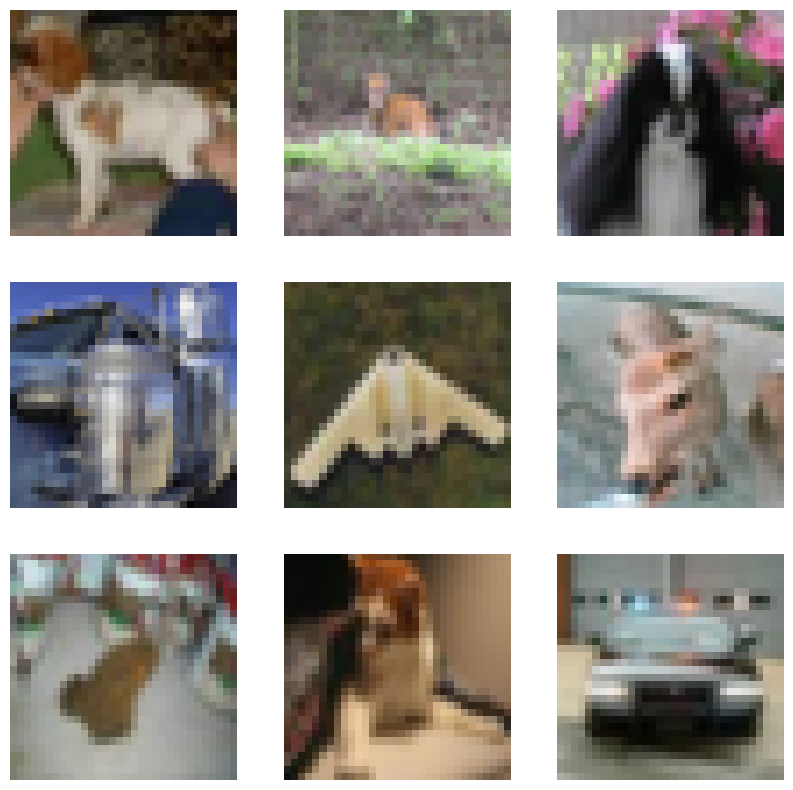

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
hh=np.load(".../Paper_Diff_testing/DRFuzz-main/Failures_images/CIFAR10_S1/time_2h/run2/triggering_f.npy", allow_pickle=True)

print("trig:",len(hh))
# ,"len reg", len(hR), "len both", len(hB))
#RUN!
def plot_images(images, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')  # Hide axis
    plt.show()


import numpy as np

# Assuming hh is a list of objects, each with a ref_image attribute
images_hh = [hh[i].ref_image for i in range(len(hh))]

# Convert the list of images to a numpy array
images_array = np.array(images_hh)

# Check the shape of the resulting array
print(images_array.shape)

# Plot the first 9 images from the array
jj=np.array(images_array, dtype=np.uint8)
plot_images(jj, num_images=9)
im_bf=images_array
images_array = images_array / 255.0




In [ ]:
images_array.max()

1.0

In [ ]:
# Number of repetitions and subset size
num_repetitions = 30
subset_size = 1000

# Initialize dictionaries to store cumulative scores
cumulative_scores_DR = {
    "Geometric Diversity (GD)": 0,
    "Shannon P": 0
}

# Load VGG16 model
input_layer = layers.Input(shape=(48, 48, 3))
model_vgg16 = VGG16(weights='imagenet', input_tensor=input_layer, include_top=False)
name_layer = 'block5_conv3'
intermediate_layer_model = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer(name_layer).output)

for _ in range(num_repetitions):
    # Select a random sample
    sample_indices= random.sample(range(len(images_array)), subset_size)
    images_DR = images_array[sample_indices]

    # Resize the images to 48x48 as required by VGG16
    x_test_DR = np.array([resize_image(im, 48) for im in images_DR])
    x_test_DR = x_test_DR.astype("float32")

    # Extract features
    FF_DR = intermediate_layer_model.predict(x_test_DR)
    features_DR = FF_DR.reshape((len(x_test_DR), -1))
    gd_score = GD(features_DR)
    if np.isinf(gd_score):
        gd_score = 0.0
    # Calculate diversity scores for this subset
    diversity_scores = {
        "Geometric Diversity (GD)": gd_score,
        "Shannon P": calculate_shannon_index_skbio(images_DR.flatten())
    }

    # Accumulate scores
    for metric, score in diversity_scores.items():
        cumulative_scores_DR[metric] += score

# Calculate average scores
average_scores_DR = {metric: score / num_repetitions for metric, score in cumulative_scores_DR.items()}

# Print the average diversity scores
for metric, score in average_scores_DR.items():
    print(f"Average {metric}: {score}")



32/32 [==============================] - 0s 4ms/step
Average Geometric Diversity (GD): 2239.356168619792
Average Shannon F: 12.920061079661052
Average Shannon P: 14.708431172530023


In [ ]:
import numpy as np
from hashlib import md5

def calculate_redundant_images(images_array):
    """
    Calculate the number of redundant or completely similar images in the image array.

    Parameters:
    images_array (numpy.ndarray): Array of images with shape (num_images, height, width, channels)

    Returns:
    int: Number of redundant image pairs
    """
    hash_dict = {}
    redundant_pairs = 0

    for img in images_array:
        # Normalize and convert the image to bytes for hashing
        normalized_img = img.astype("float32").tobytes()
        img_hash = md5(normalized_img).hexdigest()

        if img_hash in hash_dict:
            hash_dict[img_hash] += 1
        else:
            hash_dict[img_hash] = 1

    for count in hash_dict.values():
        if count > 1:
            redundant_pairs += count * (count - 1) // 2

    return redundant_pairs

# Example usage:
redundant_count = calculate_redundant_images(images_array)

print(f"Number of redundant image pairs: {redundant_count}")
# DRFUZZ

Number of redundant image pairs: 5326


# **RQ4**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pickle
import joblib
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

# Function to load datasets
def load_data(image_path, label_path):
    images = np.load(image_path)
    labels = np.load(label_path)
    return images, labels

# Function to check the format and scale of the images and labels
def check_image_label_format(images, labels):
    print(f"Image Shape: {images.shape}")
    print(f"Label Shape: {labels.shape}")
    print(f"Image Pixel Range: {images.min()} to {images.max()}")
    print(f"Label Range: {labels.min()} to {labels.max()}")

# Function to preprocess images: Resize to 48x48 and convert grayscale to RGB
def preprocess_images(images, target_size=(48, 48)):
    images_resized = [img_to_array(array_to_img(np.stack([img]*3, axis=-1)).resize(target_size)) for img in images]
    return np.array(images_resized) / 255.0  # Normalize to [0, 1]

# Function to extract VGG16 features
def extract_features(images_resized):
    input_layer = Input(shape=(48, 48, 3))
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
    feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block5_pool').output)
    features = feature_extractor.predict(images_resized)
    return features.reshape(features.shape[0], -1)

# Function to compare model predictions and create new labels
def create_new_labels(model1, model2, images, true_labels):
    images = images / 255.0
    predictions_model1 = model1.predict(images)
    predictions_model2 = model2.predict(images)
    predicted_labels_model1 = np.argmax(predictions_model1, axis=1)
    predicted_labels_model2 = np.argmax(predictions_model2, axis=1)

    new_labels = [3 if p1 == t == p2 else 1 if p1 == t else 2 if p2 == t else -1
                  for p1, p2, t in zip(predicted_labels_model1, predicted_labels_model2, true_labels)]
    return new_labels

# Function to train and evaluate a Random Forest model
def train_random_forest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=100)
    cv_scores = cross_val_score(rf, X_train, y_train, cv=4)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation accuracy: {np.mean(cv_scores) * 100:.2f}%")

    rf.fit(X_train, y_train)
    test_accuracy = rf.score(X_test, y_test)
    print(f"Random Forest Accuracy on the test set: {test_accuracy * 100:.2f}%")
    return rf

# Main pipeline for a dataset
def process_dataset(image_path, label_path, model1, model2):
    images, labels = load_data(image_path, label_path)
    check_image_label_format(images, labels)

    images_resized = preprocess_images(images)
    features = extract_features(images_resized)

    new_labels = create_new_labels(model1, model2, images, labels)
    return features, new_labels

# Function to save a Random Forest model
def save_rf_model(rf_model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(rf_model, f)

# Function to find and save the best tree from the Random Forest
def find_best_tree(rf_model, X_test, y_test):
    best_accuracy = 0
    best_tree_index = -1
    best_tree_model = None

    for i, tree in enumerate(rf_model.estimators_):
        tree_predictions = tree.predict(X_test)
        accuracy = accuracy_score(y_test - 1, tree_predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_tree_index = i
            best_tree_model = tree

    print(f"Best tree index: {best_tree_index}, Accuracy: {best_accuracy:.4f}")
    joblib.dump(best_tree_model, "best_tree_model.pkl")


In [ ]:
# Function to train and evaluate a Random Forest model
def train_random_forest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=100)
    cv_scores = cross_val_score(rf, X_train, y_train, cv=4)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation accuracy: {np.mean(cv_scores) * 100:.2f}%")

    rf.fit(X_train, y_train)
    test_accuracy = rf.score(X_test, y_test)
    print(f"Random Forest Accuracy on the test set: {test_accuracy * 100:.2f}%")
    return rf

# Main pipeline for processing dataset
def process_dataset_and_train(image_path, label_path, model1, model2):
    # Load and preprocess dataset
    images, labels = load_data(image_path, label_path)
    check_image_label_format(images, labels)

    # Preprocess images and extract features
    images_resized = preprocess_images(images)
    features = extract_features(images_resized)

    # Generate new labels based on model predictions
    new_labels = create_new_labels(model1, model2, images, labels)

    # Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, new_labels, test_size=0.2, random_state=42)

    # Train Random Forest model
    rf_model = train_random_forest(X_train, y_train, X_test, y_test)

    # Save the trained model
    save_rf_model(rf_model, 'rf_model.pkl')

    return rf_model

# Paths to your datasets
drfuzz_images_path = "/path/to/drfuzz_images.npy"
drfuzz_labels_path = "/path/to/drfuzz_labels.npy"

# Load your pre-trained models
model1 = load_model_without_lr_decay('/path/to/model1.h5')
model2 = load_model_without_lr_decay('/path/to/model2.h5')

# Process the dataset and train the Random Forest model
rf_model = process_dataset_and_train(drfuzz_images_path, drfuzz_labels_path, model1, model2)


## Training based on paper

In [ ]:
import numpy as np
from sklearn.utils import shuffle

# Process DiffGAN dataset and extract features
print("Processing DiffGAN dataset...")
diffgan_features, diffgan_new_labels, img_diffgan, label_diffgan = process_dataset1(
    diffgan_images_path, diffgan_labels_path, model1, model2
)

# Shuffle DiffGAN features, labels, images, and true labels in unison
Sh_diffgan_features, SH_diffgan_new_labels, SH_img_diffgan, SH_label_diffgan = shuffle(
    diffgan_features, diffgan_new_labels, img_diffgan, label_diffgan, random_state=42
)

# Assuming DRFuzz dataset has been processed similarly
# Stack arrays for DRFuzz dataset (features, labels, etc.)
X_train, X_test = Sh_drfuzz_features[:700], Sh_drfuzz_features[700:800]
images_train, images_test = SH_img_drfuzz[:700], SH_img_drfuzz[700:800]
org_label_train, org_label_test = SH_label_drfuzz[:700], SH_label_drfuzz[700:800]
y_train, y_test = SH_drfuzz_new_labels[:700], SH_drfuzz_new_labels[700:800]

# Concatenate DiffGAN and DRFuzz test sets for joint evaluation
y_test_DR = np.concatenate((y_test, SH_diffgan_new_labels[700:800]), axis=0)
X_test_DR = np.concatenate((X_test, Sh_diffgan_features[700:800]), axis=0)
y_test_DR_LB = np.concatenate((org_label_test, SH_label_diffgan[700:800]), axis=0)
X_test_DR_IMG = np.concatenate((images_test, SH_img_diffgan[700:800]), axis=0)

# Train Random Forest model on DRFuzz features
rf_model_drfuzz = train_random_forest(X_train, y_train, X_test_DR, y_test_DR)

# Train Random Forest model on DiffGAN features
rf_model_diffgan1 = train_random_forest(Sh_diffgan_features[:700], SH_diffgan_new_labels[:700], X_test_DR, y_test_DR)
